In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import shutil
shutil.unpack_archive("/content/drive/MyDrive/SEMINAR/Combined Labels/Dataset/dataset.zip")

#  Import Libraries

In [3]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import plotly.graph_objects as go
import plotly.express as px
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import callbacks
import seaborn as sns
from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.backend as K
import tensorflow_hub as hub
import matplotlib.image as img

# Define Constants

In [4]:
train_dir = "/content/Training"

test_dir = "/content/Testing"

img_size = (224 , 224)

batch_size = 32

# Getting the data 

In [5]:
#Define train_data
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir ,
    image_size = img_size ,
    label_mode = "int" ,
    batch_size = batch_size ,
    )

#Define Classes Names
class_names= train_data.class_names
class_names


Found 5712 files belonging to 4 classes.


['glioma', 'meningioma', 'notumor', 'pituitary']

##  visualizing some Random Samples

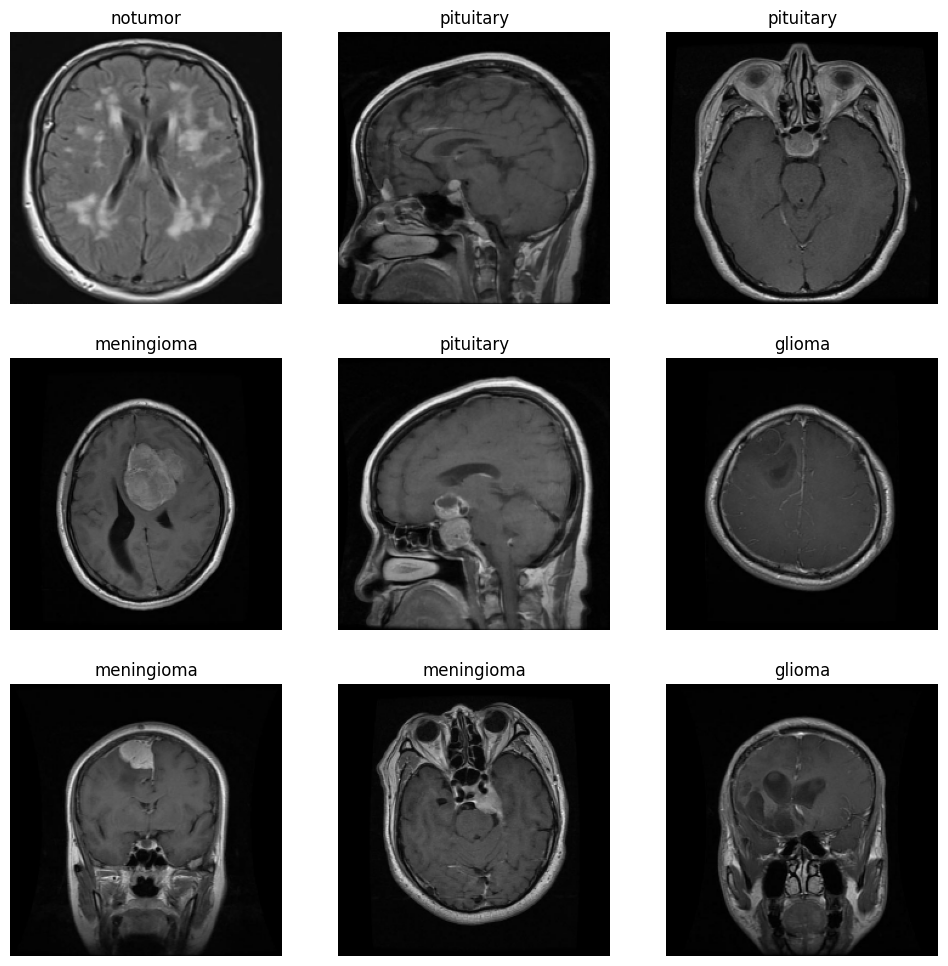

In [6]:
plt.figure(figsize=(12, 12))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
#Deifne a Function to get number of each class samples
def each_class_samples(train_data):
    """
    taking the train data and returns the number of each class samples

    """
    #Set up counters
    meningioma = 0
    notumor = 0
    glioma = 0
    pituitary = 0

    #Looping over the train_data
    for images, labels in train_data:
        for i in range(len(images)):
            if class_names[labels[i]] == 'meningioma':
                meningioma +=1
            elif class_names[labels[i]] == 'notumor':
                notumor +=1
            elif class_names[labels[i]] == 'glioma':
                glioma +=1
            elif class_names[labels[i]] == 'pituitary':
                pituitary +=1
    print("meningioma : " + str(meningioma))
    print("glioma : " + str(glioma))
    print("notumor : " + str(notumor))
    print("pituitary : " + str(pituitary))
    return [meningioma , glioma , notumor , pituitary]




#Trying our function
meningioma  , glioma , notumor , pituitary = each_class_samples(train_data)

meningioma : 1339
glioma : 1321
notumor : 1595
pituitary : 1457


In [8]:
# Plotting numbers of each class
fig = go.Figure(go.Bar(
            x= [meningioma,glioma,pituitary,notumor],
            y= ['meningioma','glioma','pituitary','notumor'],
            orientation='h' ,) )

fig.update_layout(title='Brain Tumor Distribution',font_size=15,title_x=0.45)


fig.show()

In [9]:
import plotly.graph_objs as go

# Sample data for the number of images for each tumor type
# meningioma = 150
# glioma = 200
# pituitary = 180
# notumor = 120

# Colors for each tumor class
colors = ['rgba(255, 65, 54, 0.6)',  # Red for Meningioma
          'rgba(93, 164, 214, 0.6)',  # Blue for Glioma
          'rgba(255, 133, 27, 0.6)',  # Orange for Pituitary
          'rgba(127, 212, 150, 0.6)'  # Gray for No Tumor
          ]

# Creating the bar chart with custom colors
fig = go.Figure(go.Bar(
    x=['Meningioma', 'Glioma', 'Pituitary', 'No Tumor'],
    y=[meningioma, glioma, pituitary, notumor],
    orientation='v',  # Vertical orientation
    width=0.5,  # Adjusting the bar width (smaller value for smaller bars)
    marker_color=colors  # Assigning custom colors
))

# Updating layout with axis labels and title, and adjusting figure size
fig.update_layout(
    title='Brain Tumor Distribution',
    xaxis_title='Tumor Type',
    yaxis_title='No. of Images',
    font=dict(size=15),
    title_x=0.5,  # Centering the title
    barmode='group',  # Display bars in groups
    width=600,  # Adjusting the figure width
    height=400  # Adjusting the figure height
)

# Display the plot
fig.show()


#  Modelling_1 (Using EfficientNetB0)

## Defining Data and callBack_List


In [10]:
#Defining some constants
img_size = (224 , 224)
batch_size = 32


#Defining train_data again
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir ,
    image_size = img_size ,
    label_mode = "categorical" ,
    batch_size = batch_size ,)


#Defining Test_data
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir ,
    image_size = img_size ,
    label_mode = "categorical" ,
    batch_size = batch_size ,)


#Defining CallBack list

callback_list=[
    callbacks.EarlyStopping(monitor="val_accuracy",patience=10,restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.8,monitor="val_accuracy",patience=3)
]

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


## Modelling
* First Stage : BaseModel(Freezed) . add[Conv2D layer(`will help us in the segmentation part`)] . add[Global avg pooling layer] . add[Dense Layer] and train for 5 epochs
* Second Stage: BaseModel(un freeze last 10 layers) . ReCompile[and reduce learning rate by 10x]
* Last : [Apply Grad Cam Segmentation]

### 1.First Stage - Building the model



In [11]:

#--Define Base_Model (EfficientNetB0)

base_model = tf.keras.applications.EfficientNetB0(include_top = False) #excluding the top layer

base_model.trainable = False #--> Freezing the model parameters (Make it's parameter not learnable)

inputs = tf.keras.layers.Input(shape = (224 , 224 , 3) , name = "Input_layer") #--> Define the input layer

x = base_model(inputs)

x = Conv2D(32 , 3 , padding = 'same' , activation = "relu" , name = "Top_Conv_Layer")(x) #--> add a Conv2D layer which we will use in the segmentation as the Top conv Layer

x = tf.keras.layers.GlobalAveragePooling2D(name = "Global_avg_Pooling_2D")(x) #--> Add Global Average Pooling Layer 2D

outputs = tf.keras.layers.Dense(4 , #--> Because we have 4 Classes
                                activation = "softmax" , #we will change it to linear when we apply sigmentation
                                name = "Output_layer")(x)
Model_1 = tf.keras.Model(inputs , outputs) #--> Defining the model


#Compile the model

Model_1.compile(
    loss = tf.keras.losses.categorical_crossentropy ,#--> Multiclass classification
    optimizer = tf.keras.optimizers.Adam() , #--> Adam optimizer with Learning_rate = 0.001
    metrics = ['accuracy']
)


#Fitting the model for 5 epochs

Model_1_History = Model_1.fit(train_data
                              , validation_data = test_data ,
                              epochs = 5  ,
                              verbose = 1 ,
                              callbacks = callback_list)
Model_1.save('/content/drive/MyDrive/SEMINAR/Combined Labels/BT_GC_Stage1.h5')


16705208/16705208 [==============================] - 1s 0us/step
Epoch 1/5
179/179 [==============================] - 33s 117ms/step - loss: 0.3733 - accuracy: 0.8589 - val_loss: 0.2612 - val_accuracy: 0.8970 - lr: 0.0010
Epoch 2/5
179/179 [==============================] - 16s 90ms/step - loss: 0.1972 - accuracy: 0.9284 - val_loss: 0.1852 - val_accuracy: 0.9237 - lr: 0.0010
Epoch 3/5
179/179 [==============================] - 16s 89ms/step - loss: 0.1361 - accuracy: 0.9503 - val_loss: 0.1445 - val_accuracy: 0.9489 - lr: 0.0010
Epoch 4/5
179/179 [==============================] - 26s 142ms/step - loss: 0.1134 - accuracy: 0.9575 - val_loss: 0.1660 - val_accuracy: 0.9436 - lr: 0.0010
Epoch 5/5
179/179 [==============================] - 16s 88ms/step - loss: 0.0898 - accuracy: 0.9681 - val_loss: 0.1181 - val_accuracy: 0.9497 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [12]:
Model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 Top_Conv_Layer (Conv2D)     (None, 7, 7, 32)          368672    
                                                                 
 Global_avg_Pooling_2D (Glo  (None, 32)                0         
 balAveragePooling2D)                                            
                                                                 
 Output_layer (Dense)        (None, 4)                 132       
                                                                 
Total params: 4418375 (16.85 MB)
Trainable params: 368804 (1.

## Plot loss curves

In [13]:
#Define the function to plot loss and accuracy curves of train - valid
def plot_loss_curves(history):
    train_loss = history.history["loss"]
    val_loss = history.history['val_loss']
    train_accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))
    #Plot Loss
    plt.plot(epochs , train_loss , label = "Train Loss")
    plt.plot(epochs , val_loss , label = "Val Loss" )
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()
    #Plot accuracy
    plt.figure()
    plt.plot(epochs ,train_accuracy , label = "train_accuracy")
    plt.plot(epochs , val_accuracy , label = "val_accuracy" )
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

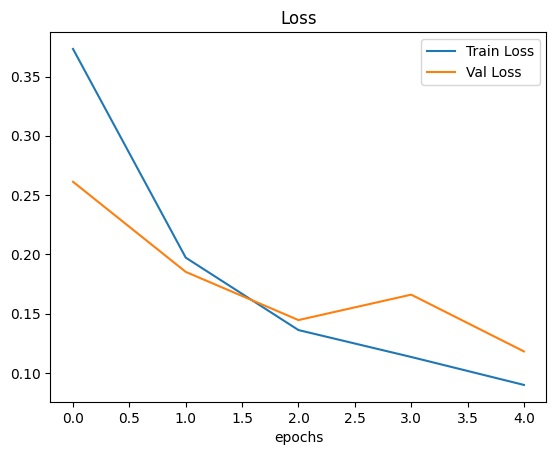

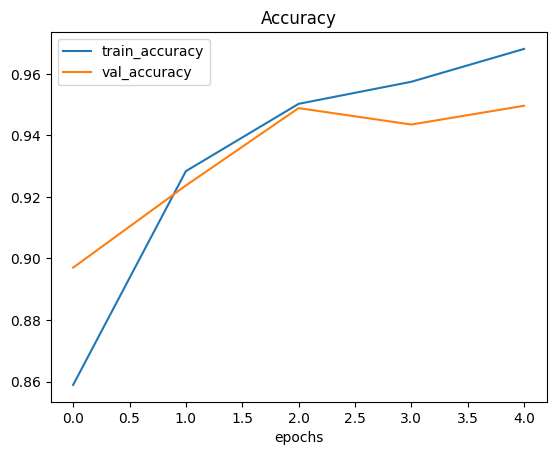

In [14]:
#Use out function
plot_loss_curves(Model_1_History)

## Second Stage Training
* unfreaze Last 10 Layers of the Base model
* Lower the learning rate of Adam optimizer

In [15]:
# Un freaze all the Base_model
base_model.trainable = True

#Freezing all the layers except last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False


#ReCompile the model
Model_1.compile(loss = "categorical_crossentropy" ,
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001), #--< When FineTuning u want to lower the LR by 10x
                metrics = ["accuracy"]
               )


#FineTune for 10 epochs
initial_epoch = 5

Fine_Tune_epoch = initial_epoch + 5

#Refit the model
Stage_2_history = Model_1.fit(train_data ,
                              epochs = Fine_Tune_epoch ,
                              validation_data = test_data ,
                              validation_steps = len(test_data) ,
                              initial_epoch = initial_epoch-1)
Model_1.save('/content/drive/MyDrive/SEMINAR/Combined Labels/BT_GC_Stage2.h5')

Epoch 5/10
179/179 [==============================] - 29s 107ms/step - loss: 0.0991 - accuracy: 0.9669 - val_loss: 0.0930 - val_accuracy: 0.9634
Epoch 6/10
179/179 [==============================] - 17s 91ms/step - loss: 0.0477 - accuracy: 0.9846 - val_loss: 0.0886 - val_accuracy: 0.9649
Epoch 7/10
179/179 [==============================] - 17s 90ms/step - loss: 0.0397 - accuracy: 0.9886 - val_loss: 0.0784 - val_accuracy: 0.9657
Epoch 8/10
179/179 [==============================] - 16s 90ms/step - loss: 0.0368 - accuracy: 0.9881 - val_loss: 0.0753 - val_accuracy: 0.9733
Epoch 9/10
179/179 [==============================] - 17s 95ms/step - loss: 0.0343 - accuracy: 0.9893 - val_loss: 0.0687 - val_accuracy: 0.9756
Epoch 10/10
179/179 [==============================] - 17s 90ms/step - loss: 0.0258 - accuracy: 0.9923 - val_loss: 0.0684 - val_accuracy: 0.9741


In [16]:
Model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 Top_Conv_Layer (Conv2D)     (None, 7, 7, 32)          368672    
                                                                 
 Global_avg_Pooling_2D (Glo  (None, 32)                0         
 balAveragePooling2D)                                            
                                                                 
 Output_layer (Dense)        (None, 4)                 132       
                                                                 
Total params: 4418375 (16.85 MB)
Trainable params: 1262036 (4

In [17]:
#ReCompile the model and reduce Learning rate by 10x
Model_1.compile(loss = "categorical_crossentropy" ,
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001), #--< lower the LR by 10x
                metrics = ["accuracy"]
               )
initial_epoch = 10
Fine_Tune_epoch = initial_epoch + 1
#Refit the model for 2 more epochs
Stage_2_history = Model_1.fit(train_data ,
                              epochs = Fine_Tune_epoch ,
                              validation_data = test_data ,
                              validation_steps = len(test_data) ,
                              initial_epoch = initial_epoch-1)

Model_1.save('/content/drive/MyDrive/SEMINAR/Combined Labels/BT_GC_Stage2_recompiled.h5')

Epoch 10/11
179/179 [==============================] - 28s 105ms/step - loss: 0.0190 - accuracy: 0.9951 - val_loss: 0.0601 - val_accuracy: 0.9794
Epoch 11/11
179/179 [==============================] - 16s 90ms/step - loss: 0.0174 - accuracy: 0.9968 - val_loss: 0.0600 - val_accuracy: 0.9779


In [18]:
Model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 Top_Conv_Layer (Conv2D)     (None, 7, 7, 32)          368672    
                                                                 
 Global_avg_Pooling_2D (Glo  (None, 32)                0         
 balAveragePooling2D)                                            
                                                                 
 Output_layer (Dense)        (None, 4)                 132       
                                                                 
Total params: 4418375 (16.85 MB)
Trainable params: 1262036 (4

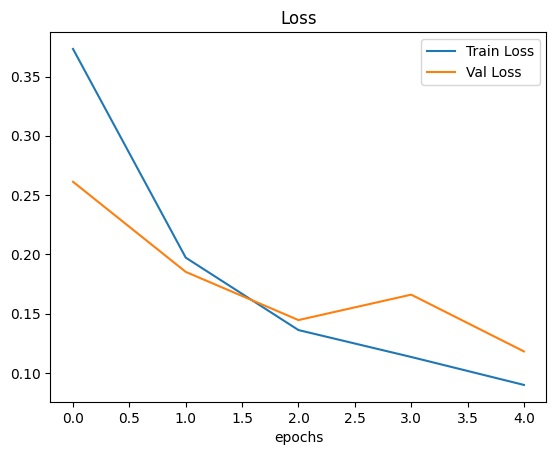

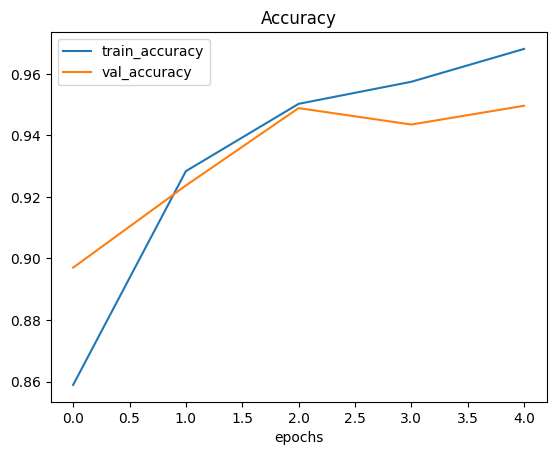

In [19]:
#Use out function
plot_loss_curves(Model_1_History)

# Segmentation part Using Grad-cam 


### Define some Functions

In [20]:
#Define Some Functions :

last_conv_layer_name = "Top_Conv_Layer"

def get_img_array(img_path, size = (224 , 224)):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array



def make_gradcam_heatmap(img_array, model = Model_1 , last_conv_layer_name = last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4 , view = False):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    if view :
        display(Image(cam_path))



def decode_predictions(preds):
    classes = ['Glioma' , 'meningioma' , 'No Tumor' , 'Pituitary']
    prediction = classes[np.argmax(preds)]
    return prediction



def make_prediction (img_path , model = Model_1 , last_conv_layer_name = last_conv_layer_name , campath = "cam.jpeg" , view = False):
    img = get_img_array(img_path = img_path)
    img_array = get_img_array(img_path, size=(224 , 224))
    preds = Model_1.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap , cam_path=campath , view = view)
    return [campath , decode_predictions(preds)]

# Trying the segmentation on 1 MRI image


1/1 [==============================] - 3s 3s/step
meningioma


(-0.5, 317.5, 353.5, -0.5)

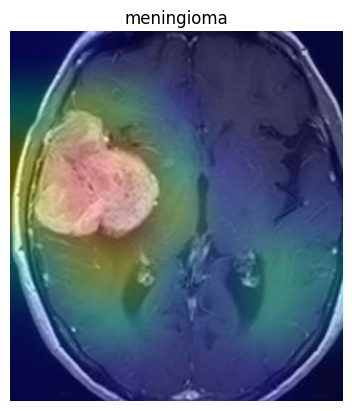

In [21]:
campath , prediction = make_prediction("/content/Testing/meningioma/Te-me_0025.jpg" , campath="123.jpeg" , view = False)
print(prediction)
test_img = img.imread(campath)
plt.imshow(test_img)
plt.title(prediction)
plt.axis("off")

# Trying the segmentation on 9 MRI images


1/1 [==============================] - 0s 31ms/step


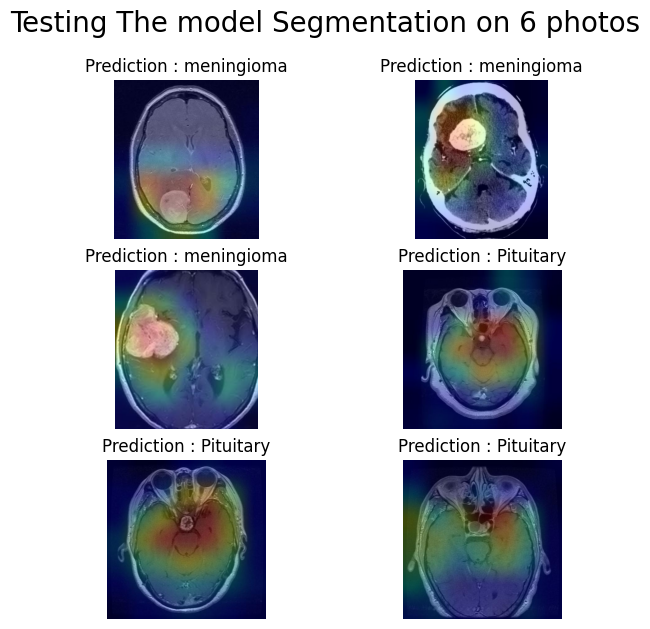

In [22]:
#Define photos paths :
path_array = [
  '/content/Testing/meningioma/Te-me_0010.jpg',
  '/content/Testing/meningioma/Te-me_0015.jpg' ,
  '/content/Testing/meningioma/Te-me_0025.jpg' ,
  '/content/Testing/pituitary/Te-pi_0010.jpg' ,
  '/content/Testing/pituitary/Te-pi_0021.jpg' ,
  '/content/Testing/pituitary/Te-pi_0030.jpg' ,

]


fig = plt.figure(figsize=(7, 7))
fig.suptitle("Testing The model Segmentation on 6 photos" , fontsize = 20)
for images, labels in train_data.take(1):
    for i in range(6):
        ax = plt.subplot(3, 2, i + 1)
        campath , prediction = make_prediction(path_array[i] , campath=f"{i}.jpeg")
        test_img = img.imread(campath)
        plt.imshow(test_img)
        plt.title("Prediction : " + prediction)
        plt.axis("off")

In [23]:
true_labels = []
predicted_labels = []


for images, labels in test_data:
    true_labels.extend(labels.numpy())
    predictions = Model_1.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

1/1 [==============================] - 0s 37ms/step


In [24]:
from sklearn.metrics import confusion_matrix
import itertools

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Get true labels and predictions
true_labels = []
predicted_labels = []

for images, labels in test_data:
    true_labels.extend(np.argmax(labels, axis=1))
    predicted_labels.extend(np.argmax(Model_1.predict(images), axis=1))


1/1 [==============================] - 0s 35ms/step


In [26]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(true_labels, predicted_labels, pos_label=3)
metrics.auc(fpr, tpr)

0.9961721068249259

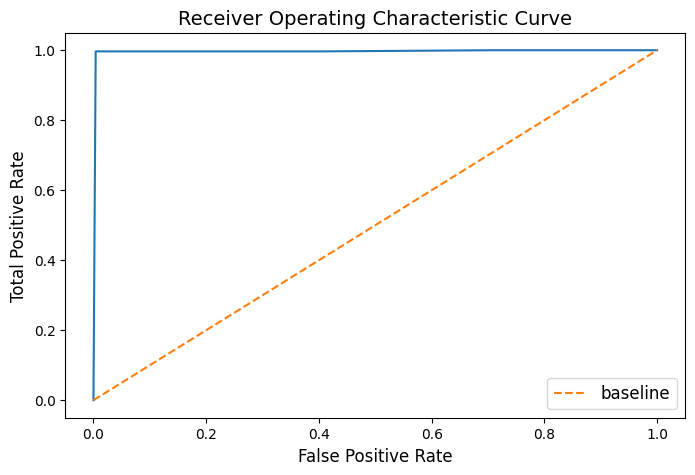

In [27]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(fpr, tpr)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=14)
plt.ylabel('Total Positive Rate', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.legend(fontsize=12);

1/1 [==============================] - 0s 34ms/step
Confusion matrix, without normalization
Normalized confusion matrix


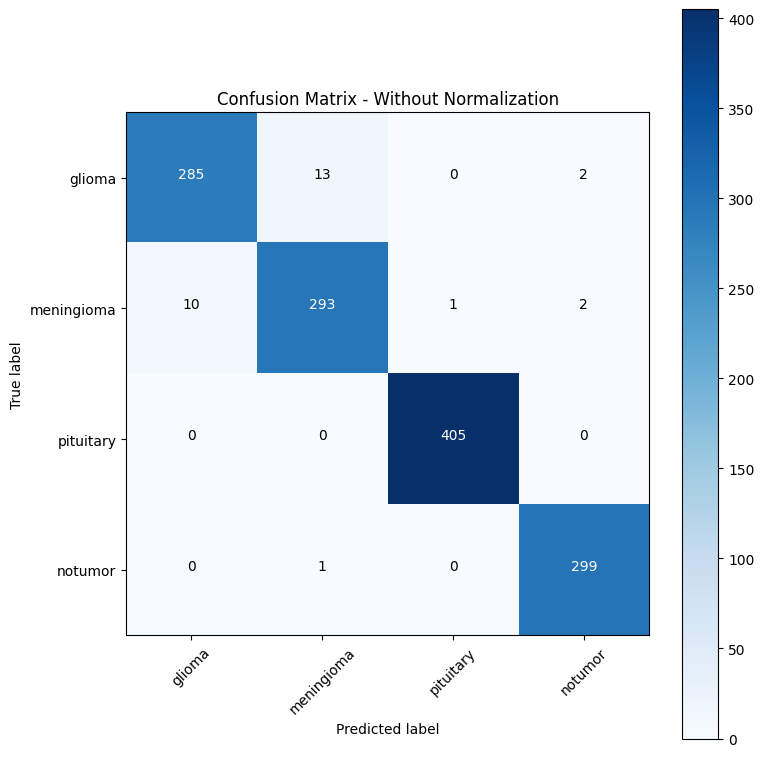

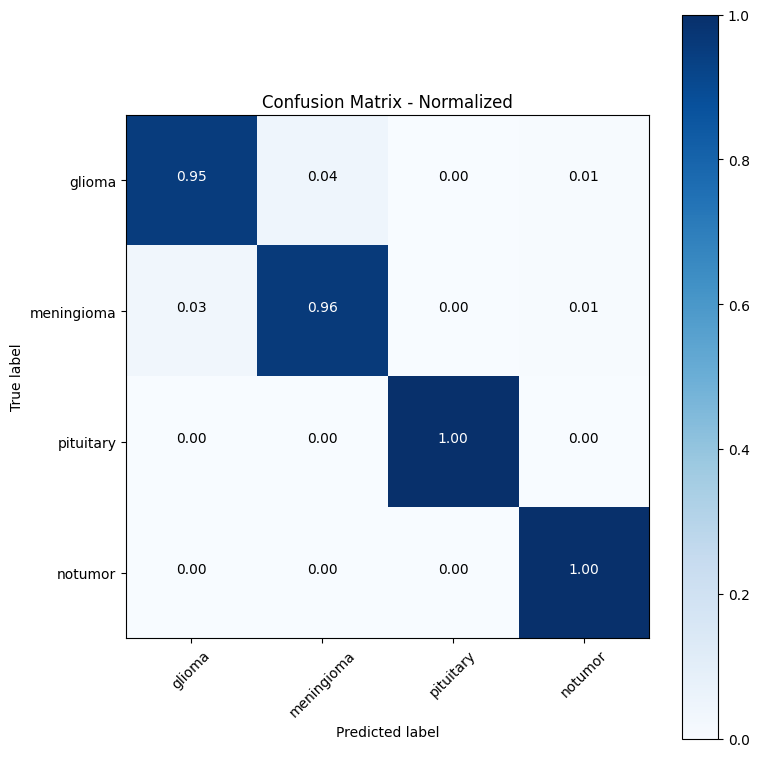

In [29]:
from sklearn.metrics import confusion_matrix
import itertools

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Get true labels and predictions
true_labels = []
predicted_labels = []

for images, labels in test_data:
    true_labels.extend(np.argmax(labels, axis=1))
    predicted_labels.extend(np.argmax(Model_1.predict(images), axis=1))

# Calculate confusion matrix
confusion_mtx = confusion_matrix(true_labels, predicted_labels)

# Define class names
class_names = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(confusion_mtx, classes=class_names, title='Confusion Matrix - Without Normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(confusion_mtx, classes=class_names, normalize=True, title='Confusion Matrix - Normalized')

plt.show()


Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.95      0.96       300
  meningioma       0.95      0.96      0.96       306
   pituitary       1.00      1.00      1.00       405
     notumor       0.99      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311

Confusion matrix, without normalization
Normalized confusion matrix


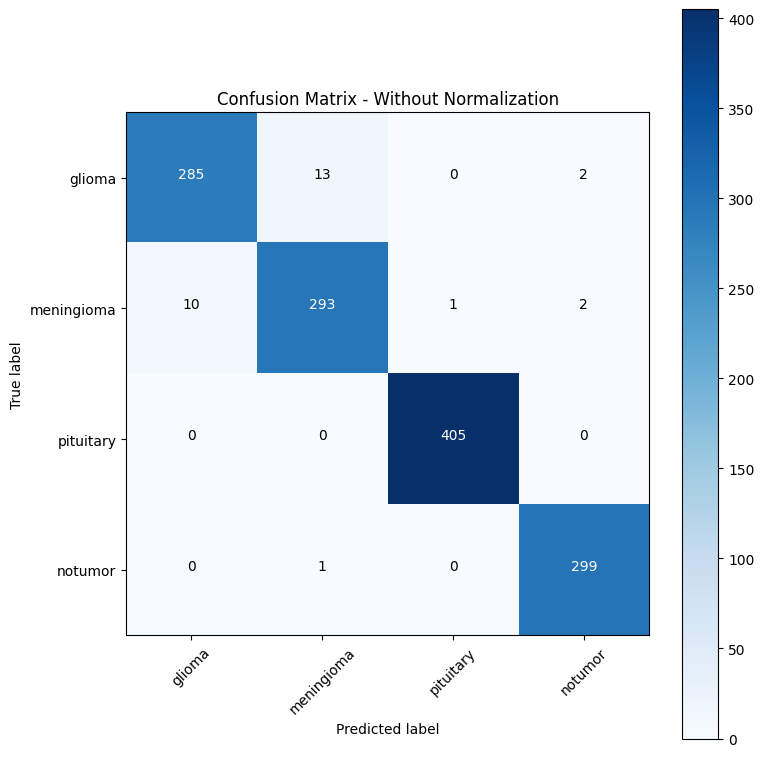

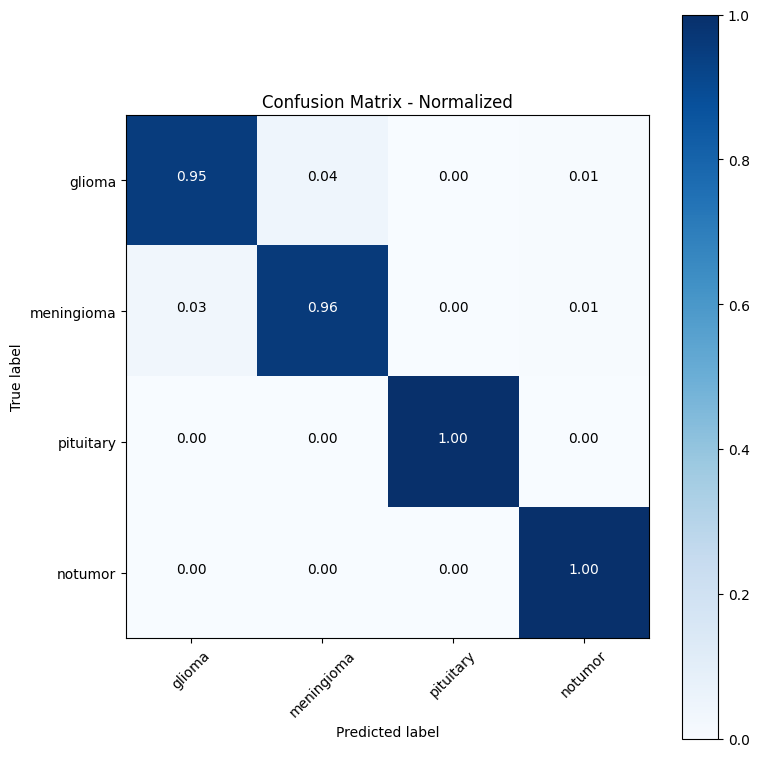

In [30]:
from sklearn.metrics import classification_report

# Get classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print classification report
print("Classification Report:")
print(report)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(confusion_mtx, classes=class_names, title='Confusion Matrix - Without Normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(confusion_mtx, classes=class_names, normalize=True, title='Confusion Matrix - Normalized')

plt.show()


In [31]:
# Accessing the final training and validation accuracy
final_train_accuracy = Model_1_History.history['accuracy'][-1]
final_val_accuracy = Model_1_History.history['val_accuracy'][-1]

# Printing the final accuracy
print("Final Training Accuracy:", final_train_accuracy)
print("Final Validation Accuracy:", final_val_accuracy)


Final Training Accuracy: 0.968137264251709
Final Validation Accuracy: 0.9496567249298096


Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.95      0.96       300
  meningioma       0.95      0.96      0.96       306
   pituitary       1.00      1.00      1.00       405
     notumor       0.99      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311

Confusion matrix, without normalization
Normalized confusion matrix


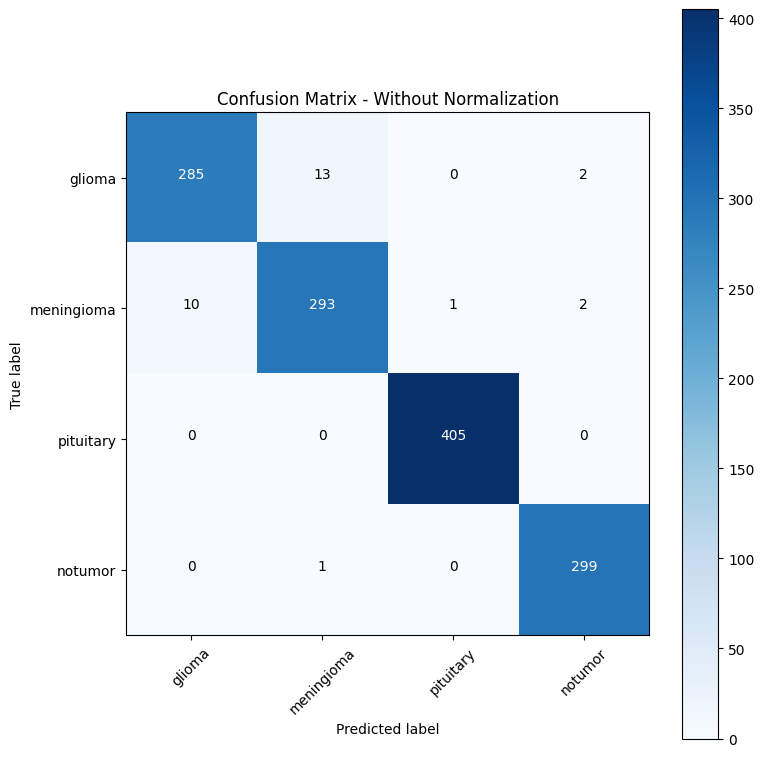

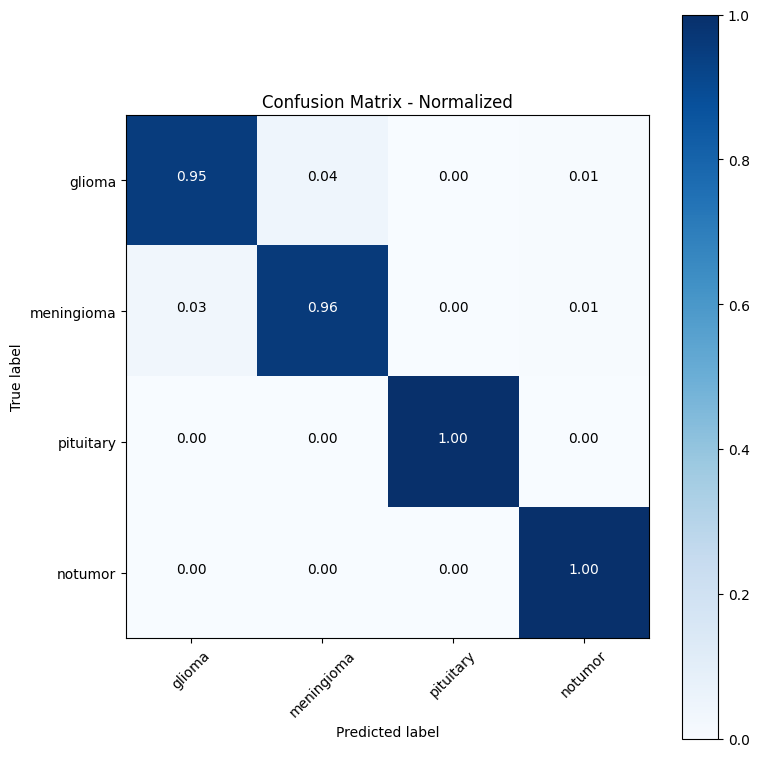

In [32]:
from sklearn.metrics import classification_report

# Get classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print classification report
print("Classification Report:")
print(report)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(confusion_mtx, classes=class_names, title='Confusion Matrix - Without Normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(confusion_mtx, classes=class_names, normalize=True, title='Confusion Matrix - Normalized')

plt.show()


In [33]:
# Accessing the final training and validation accuracy after second stage
final_train_accuracy_stage2 = Stage_2_history.history['accuracy'][-1]
final_val_accuracy_stage2 = Stage_2_history.history['val_accuracy'][-1]

# Printing the final accuracy after second stage
print("Final Training Accuracy (Stage 2):", final_train_accuracy_stage2)
print("Final Validation Accuracy (Stage 2):", final_val_accuracy_stage2)


Final Training Accuracy (Stage 2): 0.9968487620353699
Final Validation Accuracy (Stage 2): 0.9778794646263123


In [34]:
from sklearn.metrics import classification_report

# Get true labels and predictions
true_labels = []
predicted_labels = []

for images, labels in test_data:
    true_labels.extend(np.argmax(labels, axis=1))
    predicted_labels.extend(np.argmax(Model_1.predict(images), axis=1))

# Calculate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print classification report
print("Classification Report:")
print(report)


1/1 [==============================] - 0s 36ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.95      0.96       300
  meningioma       0.95      0.96      0.96       306
   pituitary       1.00      1.00      1.00       405
     notumor       0.99      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



In [35]:
from sklearn.metrics import classification_report

# Get true labels and predictions
true_labels = []
predicted_labels = []

for images, labels in test_data:
    true_labels.extend(np.argmax(labels, axis=1))
    predicted_labels.extend(np.argmax(Model_1.predict(images), axis=1))

# Calculate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print classification report
print("Classification Report:")
print(report)


1/1 [==============================] - 0s 57ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.95      0.96       300
  meningioma       0.95      0.96      0.96       306
   pituitary       1.00      1.00      1.00       405
     notumor       0.99      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



In [36]:
from sklearn.metrics import classification_report

# Get true labels and predictions
true_labels = []
predicted_labels = []

for images, labels in test_data:
    true_labels.extend(np.argmax(labels, axis=1))
    predicted_labels.extend(np.argmax(Model_1.predict(images), axis=1))

# Calculate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print classification report
print("Classification Report:")
print(report)


1/1 [==============================] - 0s 38ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.95      0.96       300
  meningioma       0.95      0.96      0.96       306
   pituitary       1.00      1.00      1.00       405
     notumor       0.99      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311

